In [15]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

import os
import pandas as pd

BASEDATADIR = "/storage/mgymrek/gtex-estrs-paper/data/"

SAVEPLOT = True
PREFIX = "eSTR-Model"
FIGPREFIX = "Figure5"

############ Load data #############
# All ref data
allstrs = pd.read_csv(os.path.join(DATADIR, "misc", "all_analyzed_strs.tab"), sep="\t")
ref = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "hg19.hipstr_reference_annot.bed"), sep="\t")
ref["str.start"]=ref["start"]
ref = pd.merge(ref, allstrs[["chrom","str.start"]].drop_duplicates(), on=["chrom","str.start"])
dnaseI = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "dnasehs_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.dnase"])

# eSTR
MIN_CAUSAL_SCORE = 0.3
estrs = pd.read_csv(os.path.join(RESULTSDIR,"SuppTable_CAVIAR.tsv"), sep="\t")
causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

Populating the interactive namespace from numpy and matplotlib


In [16]:
data = pd.merge(ref, causal, on=["chrom","str.start"])
data = pd.merge(data, dnaseI, on=["chrom","str.start"])
data["dnase"] = (data["dist.dnase"].apply(abs)<500).apply(int)

In [26]:
data["intergenic"] = ((data["coding"]+data["introns"]+data["5utr"]+data["3utr"]+data["hg19_promoter_3kb"])==0).apply(int)

{'intergenic': 422, 'coding': 11, '3utr': 55, 'hg19_promoter_1kb': 85, '5utr': 34, 'hg19_promoter_3kb': 234, 'all': 1420, 'dnase': 228, 'introns': 819}


{'3utr': array(['AC:20', 'A:11', 'AAAC:4', 'AAAT:3', 'AT:2'], dtype=object),
 '5utr': array(['CCG:11', 'AC:8', 'AGCGGC:1', 'CCCGG:1', 'CCCCGG:1'], dtype=object),
 'all': array(['A:492', 'AC:399', 'AAAT:95', 'AAAC:62', 'AT:38'], dtype=object),
 'coding': array(['AGC:3', 'CCG:2', 'AAGGCC:1', 'ACCCCC:1', 'AGCGCC:1'], dtype=object),
 'dnase': array(['AC:73', 'A:50', 'CCG:13', 'AG:9', 'AAAT:8'], dtype=object),
 'hg19_promoter_1kb': array(['AC:21', 'A:15', 'C:5', 'AT:5', 'CCG:4'], dtype=object),
 'hg19_promoter_3kb': array(['A:61', 'AC:59', 'AAAT:12', 'AAAC:11', 'C:8'], dtype=object),
 'intergenic': array(['A:170', 'AC:120', 'AAAT:23', 'AG:13', 'AT:12'], dtype=object),
 'introns': array(['A:284', 'AC:232', 'AAAT:67', 'AAAC:44', 'AT:23'], dtype=object)}

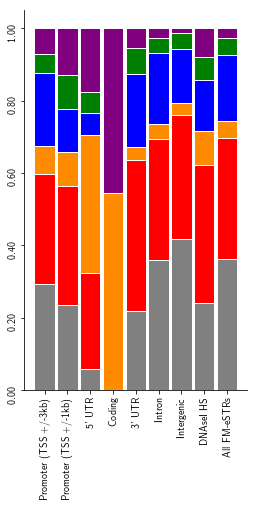

In [27]:
# Get period breakdown and top motifs for each category

annot_cols = ["hg19_promoter_3kb","hg19_promoter_1kb","5utr","coding","3utr","introns","intergenic","dnase","all"]
annot_labels = ["Promoter (TSS +/-3kb)", "Promoter (TSS +/-1kb)", "5' UTR", "Coding", "3' UTR", "Intron", "Intergenic","DNAseI HS","All FM-eSTRs"]
annot_totals = {}
annot_to_period = {}
annot_to_topmotifs = {}

for col in annot_cols:
    if col == "all":
        d = data
    else: d = data[data[col]>0]
    vals = []
    for p in range(1, 7):
        vals.append(d[d["period"]==p].shape[0]*1.0/d.shape[0])
    md = d.groupby("motif", as_index=False).agg({"str.start": len}).sort_values("str.start", ascending=False)
    annot_to_topmotifs[col] = md.apply(lambda x: "%s:%s"%(x["motif"], x["str.start"]), 1).values[0:5]
    annot_to_period[col] = vals
    annot_totals[col] = d.shape[0]


percolors = ["gray","red","darkorange","blue","green","purple"]

fig = plt.figure()
fig.set_size_inches((4, 7))
ax = fig.add_subplot(111)

xvals = range(len(annot_cols))
bottoms = [0]*len(annot_cols)
for period in range(1, 7):
    yvals = [annot_to_period[col][period-1] for col in annot_cols]
    ax.bar(xvals, yvals, bottom=bottoms, color=percolors[period-1], edgecolor="white", width=0.9)
    bottoms = [bottoms[i]+yvals[i] for i in range(len(bottoms))]
ax.set_xticks(xvals)
ax.set_xticklabels(annot_labels, rotation=90)
ax.set_yticklabels(["%.2f"%item for item in ax.get_yticks()], rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
fig.savefig(os.path.join(RESULTSDIR, "%s_annotation_breakdown.pdf"%FIGPREFIX))
print(annot_totals)
annot_to_topmotifs